We will use the [CartPole-v1](https://gym.openai.com/envs/CartPole-v0/) OpenAI Gym environment. For reproducibility, let is fix a random seed.

In [1]:
from reagent.gym.envs.gym import Gym
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
import torch
import torch.nn.functional as F
import tqdm.autonotebook as tqdm

I0108 130905.845 dataclasses.py:48] USE_VANILLA_DATACLASS: True
I0108 130905.846 dataclasses.py:49] ARBITRARY_TYPES_ALLOWED: True
W0108 130905.852 file_io.py:72] ** fvcore version of PathManager will be deprecated soon. **
** Please migrate to the version in iopath repo. **
https://github.com/facebookresearch/iopath 

W0108 130905.962 manifold.py:84] ** fvcore version of PathManager will be deprecated soon. **
** Please migrate to iopath. **

I0108 130905.963 io.py:19] Registered Manifold PathManager
W0108 130905.965 manifold.py:84] ** fvcore version of PathManager will be deprecated soon. **
** Please migrate to iopath. **

I0108 130905.965 patch.py:95] Patched torch.load, torch.save, torch.jit.load and save to handle Manifold uri
I0108 130906.068 registry_meta.py:19] Adding REGISTRY to type TrainingReport
I0108 130906.069 registry_meta.py:40] Not Registering TrainingReport to TrainingReport. Abstract method [] are not implemented.
I0108 130906.070 registry_meta.py:19] Adding REGISTRY

In [2]:
env = Gym('CartPole-v0')

I0108 130906.878 env_wrapper.py:38] Env: <TimeLimit<CartPoleEnv<CartPole-v0>>>;
observation_space: Box(4,);
action_space: Discrete(2);


In [3]:
def reset_env(env, seed):
    np.random.seed(seed)
    env.seed(seed)
    env.action_space.seed(seed)
    torch.manual_seed(seed)
    env.reset()

reset_env(env, seed=0)

The `policy` is composed of a simple scorer (a MLP) and a softmax sampler. Our `agent` simply executes this policy in the CartPole Environment.

In [4]:
from reagent.net_builder.discrete_dqn.fully_connected import FullyConnected
from reagent.gym.utils import build_normalizer

norm = build_normalizer(env)
net_builder = FullyConnected(sizes=[8], activations=["linear"])
cartpole_scorer = net_builder.build_q_network(
    state_feature_config=None, 
    state_normalization_data=norm['state'],
    output_dim=len(norm['action'].dense_normalization_parameters))

I0108 130907.285 registry_meta.py:19] Adding REGISTRY to type DiscreteDQNNetBuilder
I0108 130907.286 registry_meta.py:40] Not Registering DiscreteDQNNetBuilder to DiscreteDQNNetBuilder. Abstract method ['build_q_network'] are not implemented.
I0108 130907.286 registry_meta.py:31] Registering Dueling to DiscreteDQNNetBuilder
I0108 130907.287 dataclasses.py:73] Setting Dueling.__post_init__ to its __post_init_post_parse__
I0108 130907.289 registry_meta.py:31] Registering FullyConnected to DiscreteDQNNetBuilder
I0108 130907.289 dataclasses.py:73] Setting FullyConnected.__post_init__ to its __post_init_post_parse__
I0108 130907.291 registry_meta.py:31] Registering FullyConnectedWithEmbedding to DiscreteDQNNetBuilder
I0108 130907.291 dataclasses.py:73] Setting FullyConnectedWithEmbedding.__post_init__ to its __post_init_post_parse__


In [5]:
from reagent.gym.policies.policy import Policy
from reagent.gym.policies.samplers.discrete_sampler import SoftmaxActionSampler
from reagent.gym.agents.agent import Agent


policy = Policy(scorer=cartpole_scorer, sampler=SoftmaxActionSampler())
agent = Agent.create_for_env(env, policy)

Create a trainer that uses the REINFORCE Algorithm to train.

In [6]:
from reagent.training.reinforce import (
    Reinforce, ReinforceParams
)
from reagent.optimizer.union import classes


trainer = Reinforce(policy, ReinforceParams(
    gamma=0.99,
    optimizer=classes['Adam'](lr=5e-3, weight_decay=1e-3)
))

Transform the trajectory of observed transitions into a training batch

In [7]:
import reagent.types as rlt

def to_train_batch(trajectory):
    return rlt.PolicyGradientInput(
        state=rlt.FeatureData(torch.from_numpy(np.stack(trajectory.observation)).float()),
        action=F.one_hot(torch.from_numpy(np.stack(trajectory.action)), 2),
        reward=torch.tensor(trajectory.reward),
        log_prob=torch.tensor(trajectory.log_prob)
    )


RL Interaction Loop

In [8]:
from reagent.gym.runners.gymrunner import evaluate_for_n_episodes

eval_rewards = evaluate_for_n_episodes(100, env, agent, 500, num_processes=20)

I0108 130909.816 gymrunner.py:163] For gamma=1.0, average reward is 17.7
Rewards list: [14. 23. 14. 23. 14. 23. 14. 23. 14. 23. 14. 23. 14. 23. 14. 23. 14. 23.
 14. 23. 14. 23. 14. 23. 14. 23. 14. 23. 14. 23. 14. 23. 14. 23. 14. 23.
 14. 23. 14. 23. 25. 13. 25. 13. 25. 13. 25. 13. 25. 13. 25. 13. 25. 13.
 25. 13. 25. 13. 25. 13. 25. 13. 25. 13. 25. 13. 25. 13. 25. 13. 25. 13.
 25. 13. 25. 13. 25. 13. 25. 13. 13. 14. 13. 14. 13. 14. 13. 14. 13. 14.
 13. 14. 13. 14. 13. 14. 13. 14. 13. 14.]


In [9]:
num_episodes = 200
reward_min = 20
max_steps = 200
reward_decay = 0.8

train_rewards = []
running_reward = reward_min

from reagent.gym.runners.gymrunner import async_run_episode

with tqdm.trange(num_episodes, unit=" epoch") as t:
    for i in t:
        # using async_run_episode because Jupyter notebooks have an syncio loop, which prevents asyncio.run() from
        # working properly. use `run_episode()` if running scritps through command line.
        trajectory = await async_run_episode(env, agent, max_steps=max_steps, mdp_id=i)
        batch = to_train_batch(trajectory)
        trainer.train(batch)
        ep_reward = trajectory.calculate_cumulative_reward(1.0)
        running_reward *= reward_decay
        running_reward += (1 - reward_decay) * ep_reward
        train_rewards.append(ep_reward)
        t.set_postfix(reward=running_reward)



100%|██████████| 200/200 [00:32<00:00,  6.24 epoch/s, reward=197] 


Print the mean reward.

In [10]:
eval_episodes = 200
eval_rewards = evaluate_for_n_episodes(100, env, agent, 500, num_processes=20).T[0]

I0108 130945.789 gymrunner.py:163] For gamma=1.0, average reward is 200.0
Rewards list: [200. 200. 200. 200. 200. 200. 200. 200. 200. 200. 200. 200. 200. 200.
 200. 200. 200. 200. 200. 200. 200. 200. 200. 200. 200. 200. 200. 200.
 200. 200. 200. 200. 200. 200. 200. 200. 200. 200. 200. 200. 200. 200.
 200. 200. 200. 200. 200. 200. 200. 200. 200. 200. 200. 200. 200. 200.
 200. 200. 200. 200. 200. 200. 200. 200. 200. 200. 200. 200. 200. 200.
 200. 200. 200. 200. 200. 200. 200. 200. 200. 200. 200. 200. 200. 200.
 200. 200. 200. 200. 200. 200. 200. 200. 200. 200. 200. 200. 200. 200.
 200. 200.]


In [11]:
mean_reward = pd.Series(eval_rewards).mean()
print(f'Mean reward: {mean_reward:.2f}')

Mean reward: 200.00


Plot the rewards over training episodes.

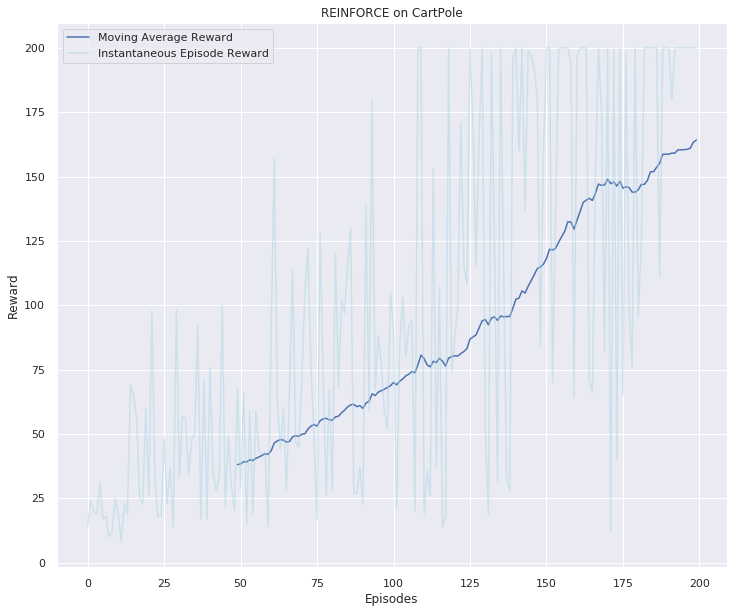

In [12]:
def plot_rewards(rewards):
    fig, ax = plt.subplots(1, 1, figsize=(12, 10));
    pd.Series(rewards).rolling(50).mean().plot(ax=ax);
    pd.Series(rewards).plot(ax=ax,alpha=0.5,color='lightblue');
    ax.set_xlabel('Episodes');
    ax.set_ylabel('Reward');
    plt.title('REINFORCE on CartPole');
    plt.legend(['Moving Average Reward', 'Instantaneous Episode Reward'])
    return fig, ax

sns.set_style('darkgrid')
sns.set()


plot_rewards(train_rewards);

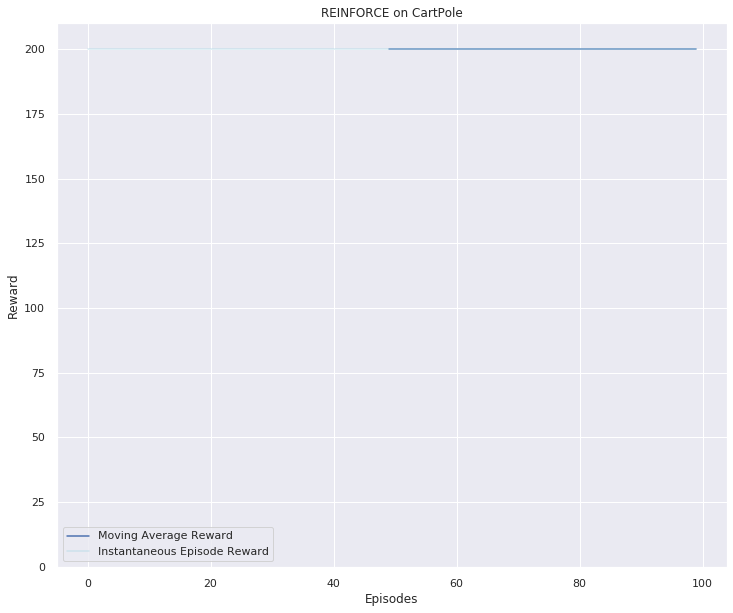

In [13]:
plot_rewards(eval_rewards);
plt.ylim([0, 210]);